# Linear Risk Model for Retinopathy in Diabetes Patients

Let's build a risk score model for retinopathy in diabetes patients using logistic regression.
  
### Brief Introduction to Diabetic Retinopathy
Diabetic Retinopathy (DR) is a progressive eye condition characterized by damage to the retinal blood vessels, often resulting in visual impairment or blindness.

As one of the leading causes of preventable vision loss worldwide, DR disproportionately affects individuals with diabetes, making early detection and risk stratification essential.

This project explores predictive modeling approaches for DR, with a focus on optimizing risk estimation in clinical datasets.

## Table of Contents

1. Import Packages
2. Load Data
3. The Dataset
    - 3.1 Explore the Dataset
    - 3.2 Check for Missing Data
    - 3.3 Check for Duplicates
    - 3.4 Assess Feature Skewness
    - 3.5 Check for Class Imbalance
4. Data Preprocessing
    - 4.1 Feature Transformation
    - 4.2 Feature Standardization
5. Build the Model
6. Evaluate the Model Using the C-Index
7. Improve the Model with Interaction Terms
8. Evalute the Improved Model
9. Future Work

## 1.  Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
np.random.seed(SEED)

## 2. Load Data

First let's load in the dataset to use for training and testing our model.

In [2]:
# Load data
X = pd.read_csv(os.path.join(os.getcwd(), 'data', 'X_data.csv'),index_col=0)
y_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'y_data.csv'),index_col=0)
y = y_df['y']

##  3. The Dataset
### 3.1 Explore the Dataset

In [3]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


The features (`X`) include the following fields:
* Age: (years)
* Systolic_BP: Systolic blood pressure (mmHg)
* Diastolic_BP: Diastolic blood pressure (mmHg)
* Cholesterol: (mg/DL)

In [4]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

The target (`y`) is an indicator of whether or not the patient developed retinopathy.

* y = 1 : patient has retinopathy.
* y = 0 : patient does not have retinopathy.

In [5]:
print(f"Input shape: {X.shape} \nOutput shape: {y.shape}")

Input shape: (6000, 4) 
Output shape: (6000,)


### 3.2 Check for Missing Data
Missing data is common in data analysis and can result from a variety of reasons such as faulty instruments, patient unwillingness to provide information, or data entry errors. Let’s check for any missing values.

In [6]:
any(y.isnull())

False

In [7]:
X.isnull().any(axis=0)  # Checking if any data is missing for each feature of X

Age             False
Systolic_BP     False
Diastolic_BP    False
Cholesterol     False
dtype: bool

### 3.3 Check for Duplicates

In [8]:
def remove_duplicates(X_, y_):
    """
    Remove duplicate rows from X and corresponding entries in y.
    Preserve the original input format (NumPy array or pandas DataFrame/Series).

    Args:
        X : np.ndarray or pd.DataFrame
            Feature matrix of shape (n_samples, n_features).
        y : np.ndarray or pd.Series
            Target vector of shape (n_samples,).

    Returns
    -------
    X_unique : same type as X_
        Feature matrix with duplicates removed.
    y_unique : same type as y_
        Target vector aligned with X_unique.
    """
    # Convert to DataFrame for uniform duplicate detection
    X_df = pd.DataFrame(X_)
    y_series = pd.Series(y_)

    # Identify unique rows
    unique_mask = ~X_df.duplicated()  # Returns True for unique rows
    #  Note: ~ is a boolean bouncer that flips the list of duplicates into a list of keepers.

    # Filter both X and y
    X_unique_df = X_df[unique_mask]
    y_unique_series = y_series[unique_mask]

    # Return in original format
    X_unique = X_unique_df.to_numpy() if isinstance(X_, np.ndarray) else X_unique_df
    y_unique = y_unique_series.to_numpy() if isinstance(y_, np.ndarray) else y_unique_series

    return X_unique, y_unique


In [9]:
X_clean, y_clean = remove_duplicates(X, y)

num_duplicates = len(y) - len(y_clean)
if num_duplicates > 0:
    print(f"Removed {num_duplicates} duplicate samples.")
else:
    print(f"No duplicate samples.")

No duplicate samples.


### 3.4 Assess Feature Skewness
Skewness can affect model performance. So let's assess feature distributions to guide potential transformations.

First, lets split our data into train and test data.

In [10]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y,random_state=SEED)

Histogram plot for each feature

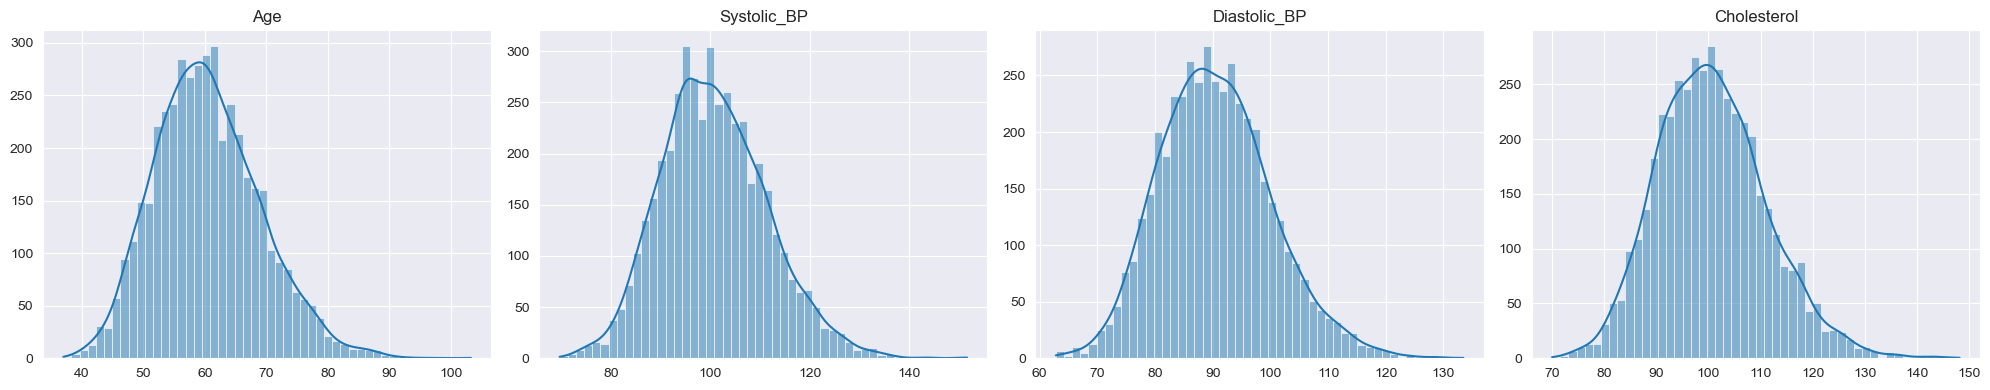

In [11]:
orig_features = X.columns
fig, axes = plt.subplots(1, len(orig_features), figsize=(20, 4))

for i, col in enumerate(orig_features):
    sns.histplot(data=X_train_raw, x=col, bins=50, kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

The distributions are roughly bell-shaped with mild right skew, deviating slightly from the symmetric Gaussian form that many statistical models assume.

Log-based transformations are effective for heavy right skew, but they can sometimes overcorrect. Instead, we'll write a function to test multiple transformations and select the one that best normalizes each feature. But first, let's check for class imbalance in the dataset.

### 3.5 Check for Class Imbalance

In [12]:
from collections import Counter

# print(np.bincount(y_train.to_numpy().astype(int)))
class_count_dict = dict(sorted(dict(Counter(y_train)).items()))
class_count_dict

{0.0: 2185, 1.0: 2315}

In [13]:
classes = np.unique(y_train).tolist()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.to_numpy())
class_weights_dict = dict(zip(classes, np.round(class_weights, 2)))
class_weights_dict

{0.0: np.float64(1.03), 1.0: np.float64(0.97)}

With class counts of 2185 and 2315, the dataset is nearly balanced. The computed weights (1.03 and 0.97) are very close to 1, which means the model won’t need to compensate much for imbalance. We can omit class_weights in the model training. But `class_weights_dict` is ready in case we change out mind.

## 4 Data Preprocessing
### 4.1 Feature Transformation

In [14]:
from scipy.stats import boxcox, yeojohnson, skew, kurtosis, shapiro
import warnings

def score_normality_transformations(data, verbose=True, include_normality_test=True, pick_by="skewness", _all_trans=False):
    """
    Evaluate and compare common data transformations for improving normality.

    Args:
        data (array-like): Input data to be transformed and evaluated. Must be 1D or convertible to 1D.

        verbose (bool): default=True.
            If True, prints a sorted summary of transformation scores and the recommended transformation.

        include_normality_test (bool): default=True
            If True, includes the Shapiro-Wilk p-value to assess normality.

        pick_by (str): default="skewness" Criterion for selecting the best transformation.

        _all_trans (bool): default=False
            If True, includes Box-Cox and Yeo-Johnson from the transformation suite.

    Returns:
        df_results (pandas.DataFrame): Summary table with skewness, kurtosis, Shapiro-Wilk p-value, and notes.

        best (str): Name of the recommended transformation.

        transformed_data (np.ndarray): Transformed version of the input data using the best transformation.
    """

    results = []
    data = np.asarray(data).ravel()

    # Base transformations
    transformations = {
        "Original": data,
        "Log": np.log(data) if np.all(data > 0) else None,
        "Log1p": np.log1p(data) if np.all(data >= 0) else None,
        "Square Root": np.sqrt(data) if np.all(data >= 0) else None,
        "Cube Root": np.cbrt(data)
    }

    # Optional transformations
    if _all_trans:
        transformations["Box-Cox"] = boxcox(data)[0] if np.all(data > 0) else None
        transformations["Yeo-Johnson"] = yeojohnson(data)[0]

    for name, transformed in transformations.items():
        if transformed is None or not isinstance(transformed, np.ndarray) or transformed.ndim != 1:
            results.append({
                "Transform": name,
                "Skewness": np.nan,
                "Kurtosis": np.nan,
                "Shapiro_p": np.nan,
                "Note": "Skipped (invalid or non-1D)"
            })
            continue

        with warnings.catch_warnings():
            # Temporarily suppressing warnings that might be triggered during statistical calculations
            warnings.simplefilter("ignore")
            skewness = skew(transformed)
            kurt = kurtosis(transformed)
            p_value = shapiro(transformed)[1] if include_normality_test else None

        results.append({
            "Transform": name,
            "Skewness": round(skewness, 6),
            "Kurtosis": round(kurt, 6),
            "Shapiro_p": round(p_value, 6) if p_value is not None else None,
            "Note": ""
        })

    df_results = pd.DataFrame(results).set_index("Transform")

    # Auto-select best transformation
    if pick_by == "skewness":
        best = df_results["Skewness"].dropna().abs().idxmin()
    elif pick_by == "p_value" and include_normality_test:
        best = df_results["Shapiro_p"].dropna().idxmax()
    else:
        best = None

    if verbose:
        print(df_results.sort_values(by="Skewness", key=lambda x: abs(x)))
        if best:
            print(f"\n--- Recommended Transformation: \033[1m{best}\033[0m (based on {pick_by})")

    transformed_data = transformations.get(best, transformations['Original'])

    return df_results, best, transformed_data

In [15]:
best_trans = {}             # To store names of the best transformation per feature
transformed_dict = {}       # To store transformed data for each feature
transformation_results = {} # To store summary of transformations per feature

for col in X.columns:
    print(f"Assessing skewness for '{col}'")
    df_res, best_for_col, transformed = score_normality_transformations(X_train_raw[col], verbose=False)
    best_trans[col] = best_for_col
    transformed_dict[col] = transformed
    transformation_results[col] = df_res

transformed_df = pd.DataFrame(transformed_dict)

Assessing skewness for 'Age'
Assessing skewness for 'Systolic_BP'
Assessing skewness for 'Diastolic_BP'
Assessing skewness for 'Cholesterol'


We can transform our data to be closer to a normal distribution by removing the skew.

In [16]:
# Best transformation per feature
best_trans

{'Age': 'Log',
 'Systolic_BP': 'Log',
 'Diastolic_BP': 'Log',
 'Cholesterol': 'Log'}

In [17]:
# Let's look at the skewness report for various transformations for a given feature (e.g., Age)
transformation_results['Age'].sort_values(by="Skewness", key=lambda x: abs(x))

,Skewness,Kurtosis,Shapiro_p,Note
Transform,,,,
Log,0.027058,-0.081147,0.861968,
Log1p,0.033764,-0.081373,0.803526,
Cube Root,0.162918,-0.032689,0.000075,
Square Root,0.231338,0.015897,0.000000,
Original,0.439988,0.266101,0.000000,


Examining the skewness values reveals that transformations do reduce asymmetry (some quite dramatically) highlighting how different methods vary in effectiveness across features.

Now, let's examine the transformed data distribution as before.

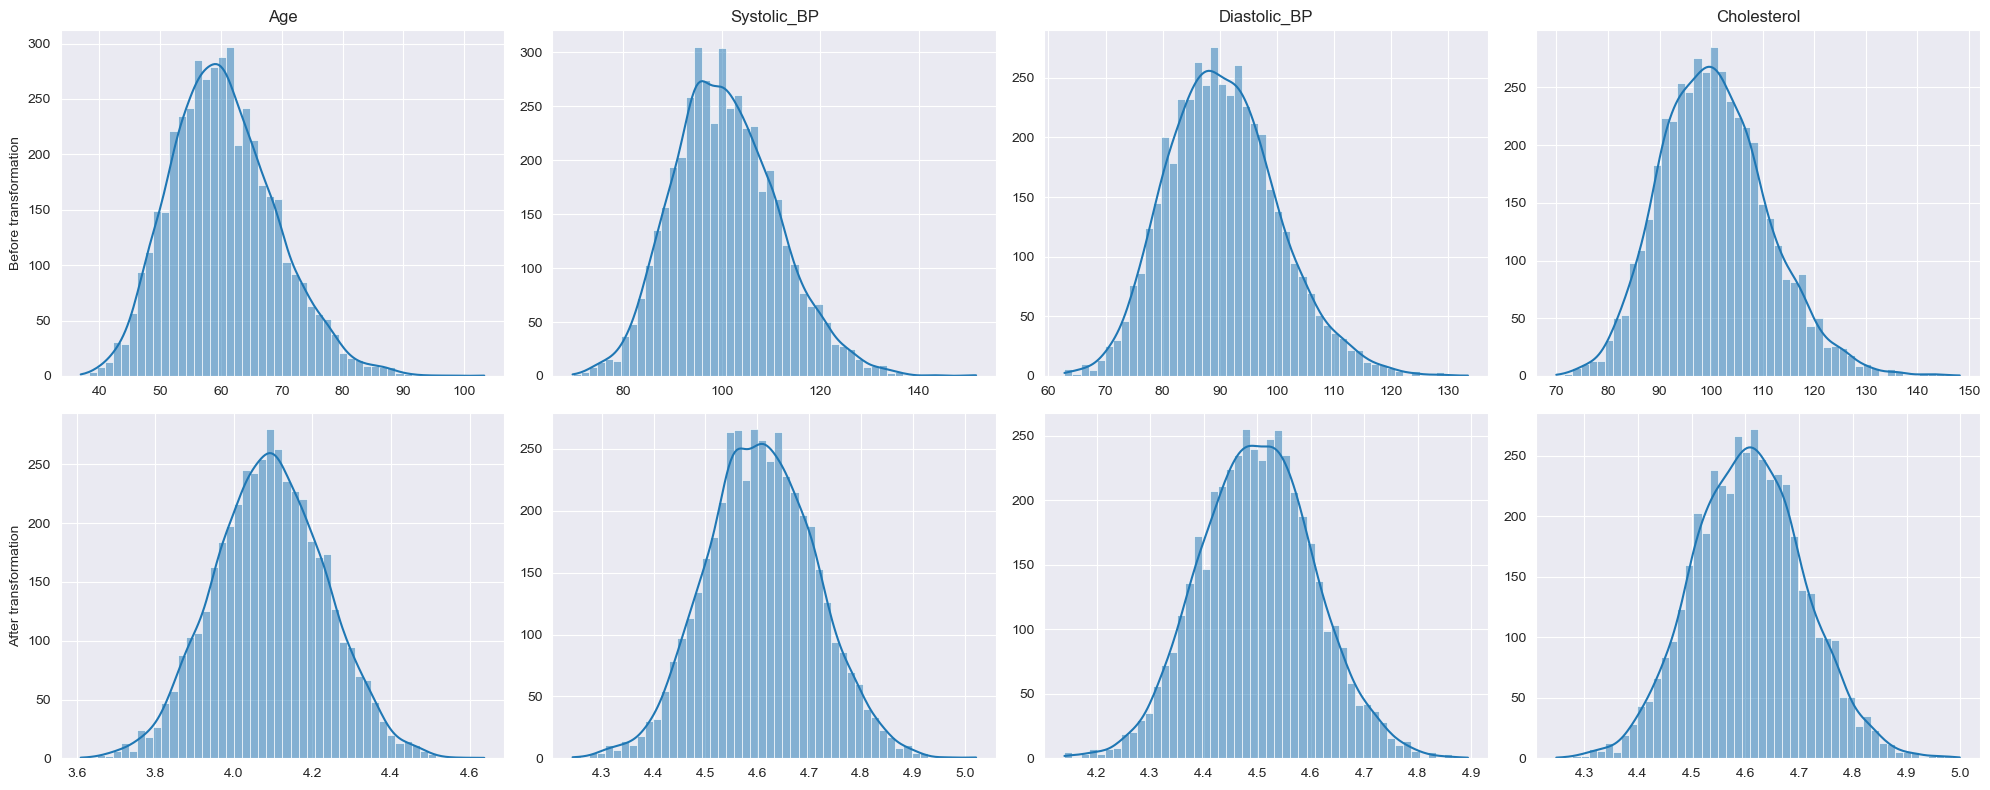

In [18]:
X_train_raw_unskewed = transformed_df.copy()

fig, axes = plt.subplots(2, len(orig_features), figsize=(20, 8))
for i, col in enumerate(orig_features):
    sns.histplot(data=X_train_raw, x=col, bins=50, kde=True, ax=axes[0, i])
    axes[0, i].set_title(col)
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('')
    if i==0:
        axes[0, i].set_ylabel('Before transformation')

    sns.histplot(data=X_train_raw_unskewed, x=col, bins=50, kde=True, ax=axes[1, i])
    # axes[1, i].set_title(col)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('')
    if i==0:
        axes[1, i].set_ylabel('After transformation')

plt.tight_layout()
plt.show()

In [19]:
def remove_skewness(data, transform_type):
    """
    Apply feature-specific transformations to reduce skewness.

    Args:
        data (pandas.DataFrame): Input DataFrame with numeric features.

        transform_type (dict): Dictionary mapping feature names to transformation names.

    Returns:
        data_unskewed : pandas.DataFrame with transformed features.
    """

    data_unskewed = pd.DataFrame(index=data.index)

    for feature, method in transform_type.items():
        col_data = data[feature].values

        if method == "Log" and np.all(col_data > 0):
            col_data_transformed = np.log(col_data)
        elif method == "Log1p" and np.all(col_data >= 0):
            col_data_transformed = np.log1p(col_data)
        elif method == "Square Root" and np.all(col_data >= 0):
            col_data_transformed = np.sqrt(col_data)
        elif method == "Cube Root":
            col_data_transformed = np.cbrt(col_data)
        elif method == "Box-Cox" and np.all(col_data > 0):
            col_data_transformed = boxcox(col_data)[0]
        elif method == "Yeo-Johnson":
            col_data_transformed = yeojohnson(col_data)[0]
        else:
            col_data_transformed = col_data  # fallback to original

        data_unskewed[feature] = col_data_transformed

    return data_unskewed

In [20]:
# Transform test dataset
X_test_raw_unskewed = remove_skewness(X_test_raw, best_trans)

### 4.2 Feature Standardization

Now, let's process the data further by standardizing the distribution to have mean zero and standard deviation 1.

In [21]:
def make_standard_normal(df_train, df_test):
    """
    Standardize the distribution with a mean of zero and standard deviation of 1.
  
    Args:
      df_train (dataframe): unnormalized training data.
      df_test (dataframe): unnormalized test data.
  
    Returns:
      df_train_normalized (dateframe): normalized training data.
      df_test_normalized (dataframe): normalized test data.
    """
    
    # Calculate the mean and standard deviation of the training set
    mean = df_train.mean(axis=0)
    stdev = df_train.std(axis=0, ddof=1)
    
    # Standardize the training set
    df_train_standardized = (df_train - mean) / stdev
    
    # Standardize the test set
    df_test_standardized = (df_test - mean) / stdev

    return df_train_standardized, df_test_standardized

In [22]:
X_train, X_test = make_standard_normal(X_train_raw_unskewed, X_test_raw_unskewed)

Let's have a look at the distributions of the transformed training data.

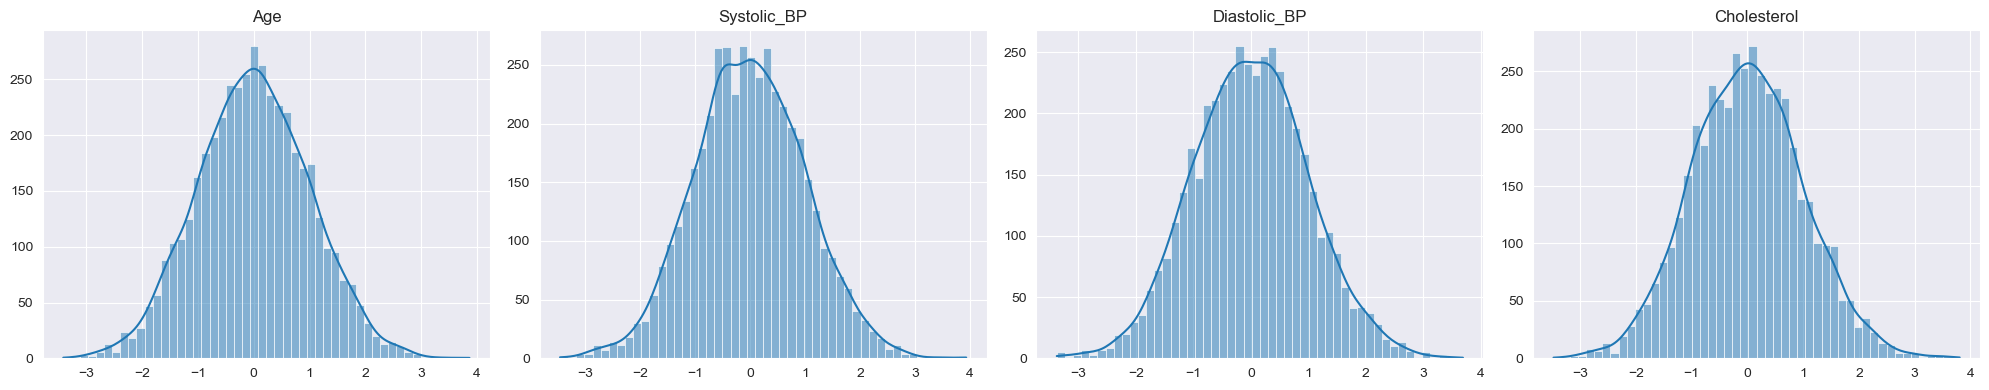

In [23]:
fig, axes = plt.subplots(1, len(orig_features), figsize=(20, 4))
for i, col in enumerate(orig_features):
    sns.histplot(data=X_train, x=col, bins=50, kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

We can see that the data is more symmetric after applying transformation and standardization.

In [24]:
X_train.describe()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
count,4.500000e+03,4.500000e+03,4.500000e+03,4.500000e+03
mean,6.082246e-15,9.837069e-15,8.510723e-16,-5.950401e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.411676e+00,-3.448990e+00,-3.375752e+00,-3.475677e+00
25%,-6.813999e-01,-6.656007e-01,-6.876896e-01,-6.882819e-01
50%,-8.893477e-03,-8.894772e-03,-6.013110e-03,-1.063171e-02
75%,6.755884e-01,6.760033e-01,6.720570e-01,6.612712e-01
max,3.865029e+00,3.928374e+00,3.690175e+00,3.806318e+00


## 5. Build the Model

Let's build the risk model by training logistic regression with our data.

In [25]:
from sklearn.metrics import make_scorer
from lifelines.utils import concordance_index

def c_index_score(y_true, y_pred):
    return concordance_index(y_true, y_pred)

c_index_scorer = make_scorer(c_index_score, greater_is_better=True)

In [26]:
def lr_model(Xtrain, ytrain, penalty='l2', cross_val=True, c_weights=None):

    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'

    assert penalty in ['l1', 'l2'], "penalty must be either 'l1' or 'l2'"

    # create the model object
    if cross_val:
        model = LogisticRegressionCV(Cs=[0.01, 0.1, 1, 2, 5, 10, 100],
                                     cv=5,
                                     penalty=penalty,
                                     solver=solver,
                                     class_weight=c_weights,
                                     scoring=c_index_scorer
                                     )
    else:
        model = LogisticRegression(C=1,
                                   penalty=penalty,
                                   solver=solver,
                                   class_weight=c_weights
                                   )

    # fit the model to the training data
    model.fit(Xtrain, ytrain)

    return model

In [27]:
model_X = lr_model(X_train, y_train, c_weights=class_weights_dict)

## 6. Evaluate the Model

Lifelines provides a built-in concordance_index, but we’ll implement a custom version for comparison.

* The C-index measures the discriminatory power of a risk score.
* Intuitively, a higher C-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the C-index is

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$

* Permissible pairs: Pairs of patients with different outcomes.
* Concordant pairs: Permissible pair in which the patient with the higher risk score also has the worse outcome.
* Ties: Equal risk scores within permissible pairs.

In [28]:
def cindex(y_true, y_pred):
    '''
    Measure the discriminatory power of a risk score.

    Args:
        y_true (np.array): 1-D array of true binary outcomes (values of zero or one)
            0: patient does not get the disease
            1: patient does get the disease
        y_pred (np.array): 1-D array of corresponding risk scores output by the model

    Returns:
        c_index (float)
    '''

    n = len(y_true)
    assert len(y_pred) == n

    concordant = 0
    permissible = 0
    ties = 0
    

    # Using two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i + 1, n):
            
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Count the pair if it's permissible
                permissible += 1

                # For permissible pairs, check if they are concordant or are ties
                # Check for ties in the score
                if y_pred[i] == y_pred[j]:
                    ties += 1
                    # if it's a tie, we don't need to check patient outcomes
                    continue

                # Case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Check if patient i has a lower risk score than patient j
                    if y_pred[i] < y_pred[j]:
                        concordant += 1

                # Case 2: patient i gets the disease, patient j does not
                if y_true[i] == 1 and y_true[j] == 0:
                    # Check if patient i has a higher risk score than patient j
                    if y_pred[i] > y_pred[j]:
                        concordant += 1

    # Calculate the C-index
    c_index = (concordant + 0.5 * ties) / permissible
    
    return c_index

In [29]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.8337


In [30]:
# Comparing custom C-index calculation to lifelines concordance_index
lifelines_cindex = c_index_score(y_test.values, scores)
assert lifelines_cindex==c_index_X_test, "The custom C-index score doesn't match lifelines C-index score"

Let's plot the coefficients to see which variables (i.e., features) are having the most impact on the outcome.

In [31]:
def plot_coefficients(coeffs, features, figure_size=(8, 2), title="Model Coefficients", print_coeffs=False):
    '''
    Visualize model coefficients as a horizontal bar plot.

    Args:
        coeffs: List or array of model coefficients (e.g., from logistic regression).
        features: List of feature names corresponding to the coefficients.
        figure_size: Size of the matplotlib figure (width, height). Default is (8, 2).
        title (str): Title of the plot. Default is "Model Coefficients".
        print_coeffs (bool): default is False. If True, prints the coefficients as a DataFrame.
    '''

    coeffs_df = pd.DataFrame({
        'Features': features,
        'Weights': coeffs
    })

    plt.figure(figsize=figure_size)
    sns.barplot(data=coeffs_df, x='Weights', y='Features')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    if print_coeffs:
        print(coeffs_df)

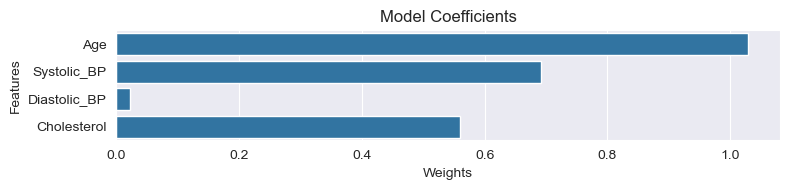

In [32]:
plot_coefficients(model_X.coef_[0], X_train.columns)

## 7. Improve the Model with Interaction Terms
To improve the model, let's introduce interaction terms. These are features that represent the combined effect of two variables.

For example, if we have data
    $$ x = [x_1, x_2]$$

We could add the product so that:
    $$ \hat{x} = [x_1, x_2, x_1*x_2]$$
    
Adding interaction terms to a model offers several key advantages:
- Captures synergy or antagonism between features, revealing how variables may amplify or dampen each other's effects.
- Improve fit when the true relationship is nonlinear but the model is linear.
- Uncovers hidden structure in the data, especially in domains like medicine or finance where context matters.
- Enable interpretable hypotheses, such as whether cholesterol affects older patients differently than younger ones.

Let's add all interactions between every pair of variables in the datasets.

In [33]:
def add_interactions(X):
    """
    Add interaction terms.

    Args:
        X (pandas.DataFrame): Original data

    Returns:
        X_int (pandas.DataFrame): Original data with interaction terms appended.
    """
    X_int = X.copy(deep=True)
    features = X.columns
    m = len(features)

    for i in range(m):
        for j in range(i + 1, m):
            f1, f2 = features[i], features[j]
            interaction_name = f"{f1}_x_{f2}"  # e.g., apple and banana -> apple_x_banana
            X_int[interaction_name] = X[f1] * X[f2]

    return X_int

In [34]:
X_train_int_raw = add_interactions(X_train)
X_test_int_raw = add_interactions(X_test)
total_features = X_train_int_raw.columns

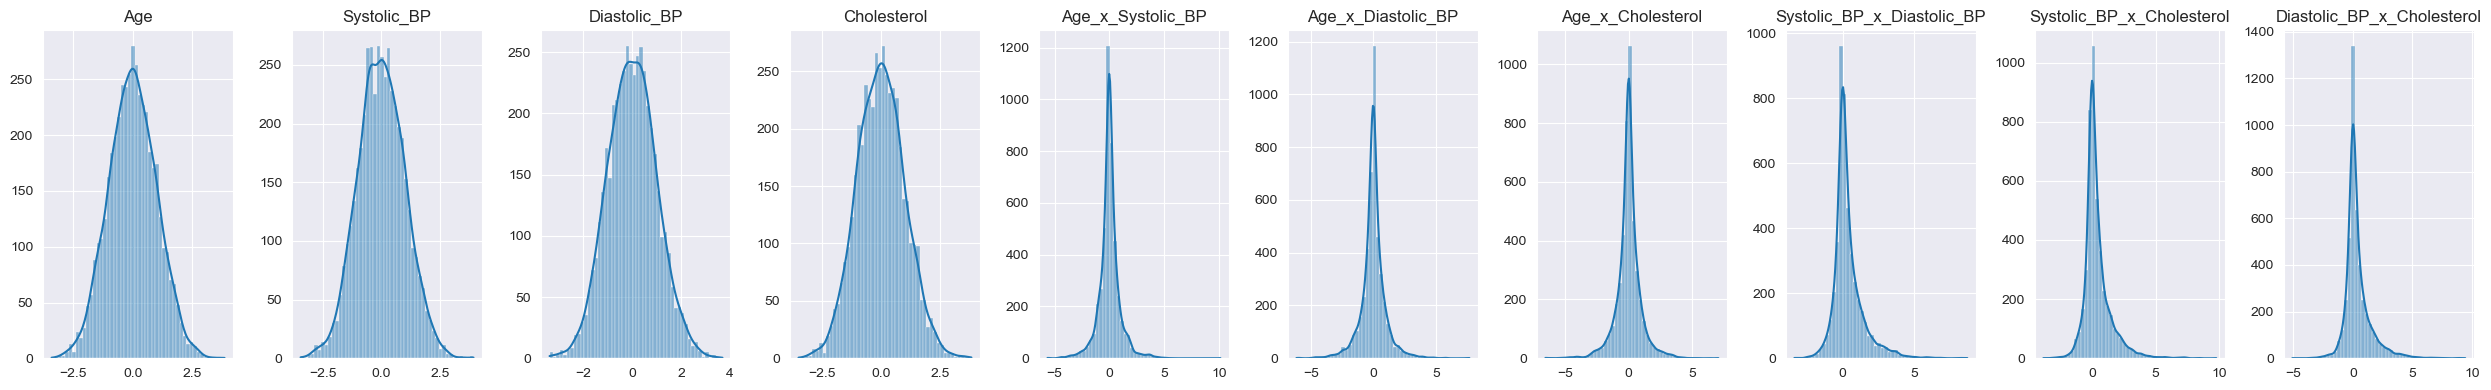

In [35]:
fig, axes = plt.subplots(1, len(total_features), figsize=(25,4))
for i, col in enumerate(total_features):
    sns.histplot(data=X_train_int_raw, x=col, bins=50, kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

Creating interaction terms from transformed and standardized features does not guarantee that the resulting terms will have mean 0 and standard deviation 1.

The product of two standardized variables can introduce skewness, shift the mean, and alter the scale

**Next step**: Standardize the interaction features to maintain model stability and interpretability, letting the raw interaction structure speak for itself.

In [36]:
num_orig_features = len(orig_features)  # Number of original features (i.e., without interaction terms)
num_orig_features

4

In [37]:
best_trans_int = {}             # To store names of the best transformation per feature
transformed_dict_int = {}       # To store transformed data for each feature
transformation_results_int = {} # To store summary of transformations per feature

for i, col in enumerate(X_train_int_raw.columns):
    print(f"Assessing skewness for '{col}'")

    if i < num_orig_features:
        # Original features were already transformed. No transformation needed.
        best_trans_int[col] = None
        transformed_dict_int[col] =X_train_int_raw[col].copy()
        transformation_results_int[col] = None

    # Assess interaction terms for skewness and transform
    else:
        df_res, best_for_col, transformed = score_normality_transformations(X_train_int_raw[col], verbose=False)
        best_trans_int[col] = best_for_col
        transformed_dict_int[col] = transformed
        transformation_results_int[col] = df_res

# Create the transformed DataFrame
transformed_df_int = pd.DataFrame(transformed_dict_int)
X_train_int_raw_unskewed = transformed_df_int.copy()

Assessing skewness for 'Age'
Assessing skewness for 'Systolic_BP'
Assessing skewness for 'Diastolic_BP'
Assessing skewness for 'Cholesterol'
Assessing skewness for 'Age_x_Systolic_BP'
Assessing skewness for 'Age_x_Diastolic_BP'
Assessing skewness for 'Age_x_Cholesterol'
Assessing skewness for 'Systolic_BP_x_Diastolic_BP'
Assessing skewness for 'Systolic_BP_x_Cholesterol'
Assessing skewness for 'Diastolic_BP_x_Cholesterol'


In [38]:
transformation_results_int["Age_x_Diastolic_BP"]

,Skewness,Kurtosis,Shapiro_p,Note
Transform,,,,
Original,0.141436,6.119546,0.0,
Log,NaN,NaN,NaN,Skipped (invalid or non-1D)
Log1p,NaN,NaN,NaN,Skipped (invalid or non-1D)
Square Root,NaN,NaN,NaN,Skipped (invalid or non-1D)
Cube Root,0.019727,-1.329390,0.0,


In [39]:
X_train_int, X_test_int = make_standard_normal(X_train_int_raw, X_test_int_raw)

In [40]:
print(f"Means\n:{X_train_int.mean(axis=0)}")
print(f"\nStandard deviations:\n{X_train_int.std(axis=0)}")

Means
:Age                           6.315935e-18
Systolic_BP                   1.421085e-17
Diastolic_BP                 -1.578984e-17
Cholesterol                   1.736882e-17
Age_x_Systolic_BP             1.302662e-17
Age_x_Diastolic_BP            3.157968e-18
Age_x_Cholesterol             3.947460e-18
Systolic_BP_x_Diastolic_BP   -3.157968e-18
Systolic_BP_x_Cholesterol    -5.289596e-17
Diastolic_BP_x_Cholesterol    2.052679e-17
dtype: float64

Standard deviations:
Age                           1.0
Systolic_BP                   1.0
Diastolic_BP                  1.0
Cholesterol                   1.0
Age_x_Systolic_BP             1.0
Age_x_Diastolic_BP            1.0
Age_x_Cholesterol             1.0
Systolic_BP_x_Diastolic_BP    1.0
Systolic_BP_x_Cholesterol     1.0
Diastolic_BP_x_Cholesterol    1.0
dtype: float64


## 8. Evaluate the Improved Model

Now, Let's train the new and improved version of the model.

In [41]:
model_X_int = lr_model(X_train_int, y_train, c_weights=class_weights_dict)

In [42]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index on test dataset without interactions is {c_index_X_test:.4f}")
print(f"c-index on test dataset with interactions is {c_index_X_int_test:.4f}")

c-index on test dataset without interactions is 0.8337
c-index on test dataset with interactions is 0.8422


The model with interaction terms performs slightly better than the model without interactions.

Let's take another look at the model coefficients to try and see which variables made a difference.

In [43]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs

,Age,Systolic_BP,Diastolic_BP,Cholesterol,Age_x_Systolic_BP,Age_x_Diastolic_BP,Age_x_Cholesterol,Systolic_BP_x_Diastolic_BP,Systolic_BP_x_Cholesterol,Diastolic_BP_x_Cholesterol
0,1.128532,0.724576,0.022958,0.603334,-0.011171,-0.022232,-0.528274,-0.029902,0.006077,0.027352


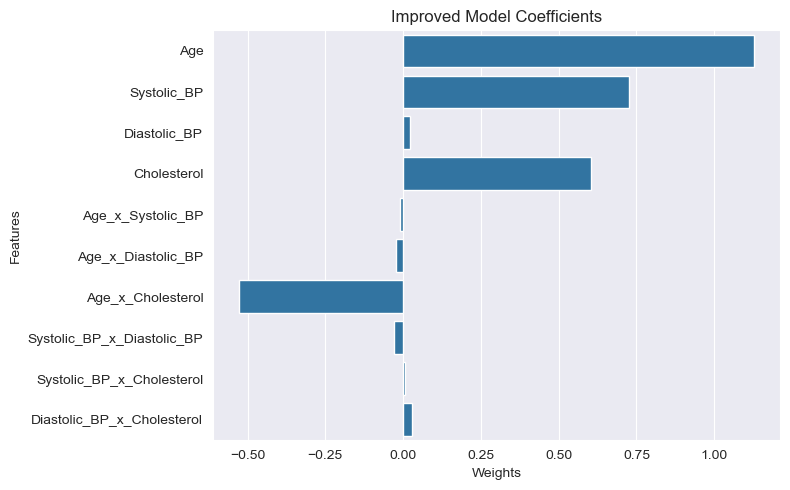

In [44]:
plot_coefficients(int_coeffs.iloc[0], X_train_int.columns, figure_size=(8, 5), title="Improved Model Coefficients", print_coeffs=False)

Age, Systolic_BP, and Cholesterol have a positive coefficient. This means that a higher value in these three features leads to a higher prediction probability for the disease.

Notice that the interaction term Age x Cholesterol has a negative coefficient. This means that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease.

With the interaction term, the model has adjusted for the fact that the effect of high cholesterol becomes less important for older patients compared to younger patients.

To understand the effect of interaction terms, let's compare the output of the trained model on sample cases with and without the interaction.

In [45]:
def filter_patients(df, age_thresh=2, chol_thresh=1, age_greater=True, chol_greater=True):
    """
    Return indices of patients based on Age and Cholesterol thresholds.

    Args:
        df (pandas.DataFrame): DataFrame containing 'Age' and 'Cholesterol' columns.
        age_thresh (float): Threshold for Age.
        chol_thresh (float): Threshold for Cholesterol.
        age_greater (bool): If True, filter Age > age_thresh; else Age < age_thresh.
        chol_greater (bool): If True, filter Cholesterol > chol_thresh; else Cholesterol < chol_thresh.

    Returns:
        matching_indices (pandas.Index): Index of rows matching the specified conditions.
    """
    age_cond = df['Age'] >= age_thresh if age_greater else df['Age'] < age_thresh
    chol_cond = df['Cholesterol'] >= chol_thresh if chol_greater else df['Cholesterol'] < chol_thresh

    mask = age_cond & chol_cond
    return df.index[mask]


In [46]:
selected = filter_patients(X_train_int, age_thresh=2, chol_thresh=2) # Old patients with high cholesterol
selected

Index([3965, 4004], dtype='int64')

In [47]:
index = 3965
case = X_train_int.iloc[index, :]
case_df = pd.DataFrame([case], columns=X_train_int.columns)
print(case)

Age                           2.500852
Systolic_BP                   1.714118
Diastolic_BP                  0.264383
Cholesterol                   2.157875
Age_x_Systolic_BP             4.279983
Age_x_Diastolic_BP            0.659024
Age_x_Cholesterol             5.422539
Systolic_BP_x_Diastolic_BP    0.048098
Systolic_BP_x_Cholesterol     3.081240
Diastolic_BP_x_Cholesterol    0.154063
Name: 3965, dtype: float64


We can see that they have above average Age and Cholesterol. We can now see what our original model would have output by zero-ing out the value for Cholesterol and Age.

In [48]:
new_case = case.copy(deep=True)
new_case_df = pd.DataFrame([new_case], columns=X_train_int.columns)

new_case_df["Age_x_Cholesterol"] = 0
# for i, col in enumerate(X_train_int.columns):
#     if i < num_orig_features:
#         continue
#
#     new_case_df[col] = 0
new_case_df

,Age,Systolic_BP,Diastolic_BP,Cholesterol,Age_x_Systolic_BP,Age_x_Diastolic_BP,Age_x_Cholesterol,Systolic_BP_x_Diastolic_BP,Systolic_BP_x_Cholesterol,Diastolic_BP_x_Cholesterol
3965,2.500852,1.714118,0.264383,2.157875,4.279983,0.659024,0,0.048098,3.08124,0.154063


In [49]:
print(f"Output with interaction: \t{model_X_int.predict_proba(case_df)[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba(new_case_df)[:, 1][0]:.4f}")

Output with interaction: 	0.9171
Output without interaction: 	0.9949


The model shows lower confidence with the interaction term, reflecting its adjustment: high cholesterol has less impact on older patients than on younger ones.

In [50]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix

def find_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Find the best threshold for binarizing predicted probabilities based on a selected metric.

    Args
        y_true : Ground truth labels.
        y_pred_proba : Predicted probabilities for the positive class.
        metric (str):cMetric to optimize: 'f1', 'sensitivity', or 'specificity'. Default is 'f1'.

    Returns
    best_thresh (float):cThreshold that maximizes the selected metric.
    """

    thresholds = np.linspace(0, 1, 101)
    all_scores = []

    for t in thresholds:
        y_pred_bin = (y_pred_proba >= t).astype(int)

        if metric == 'f1':
            score = f1_score(y_true, y_pred_bin)
        elif metric == 'sensitivity':
            score = recall_score(y_true, y_pred_bin)
        elif metric == 'specificity':
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
            score = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            raise ValueError("Unsupported metric. Choose from 'f1', 'sensitivity', or 'specificity'.")

        all_scores.append(score)

    best_thresh = thresholds[np.argmax(all_scores)]
    return best_thresh

In [51]:
y_train_pred = model_X_int.predict_proba(X_train_int)[:, 1]
best_th = find_threshold(y_train, y_train_pred, metric='f1')
print(f"The best threshold is {best_th:.3f} based on the selected metric.")

The best threshold is 0.390 based on the selected metric.


In [52]:
def performance_summary(y_true, y_pred_proba, threshold, ci_calc=None):
    '''
    Get summary of the model's performance.

    Args:
        y_true: Ground truth labels.
        y_pred_proba: Probabilities for the positive class.
        threshold: Threshold for binarizing predicted probabilities.
        ci_calc: function to compute the concordance index

    Returns:
    '''

    y_pred = y_pred_proba > threshold

    # Compute true positive, true negative, false positive, true positive
    # TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel().tolist()
    TP = np.sum((y_pred == True) & (y_true == 1))
    TN = np.sum((y_pred == False) & (y_true == 0))
    FP = np.sum((y_pred == True) & (y_true == 0))
    FN = np.sum((y_pred == False) & (y_true == 1))

    # Accuracy
    acc = (TP + TN) / (TP + TN + FP + FN)

    # Prevalence
    prevalence = np.mean(y_true)

    # Sensitivity and specificity
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)

    # PPV and NPV
    NPV = TN / (TN + FN)
    PPV = TP / (TP + FP)

    # F1 score
    F1 = 2 * (sens * PPV) / (sens + PPV)

    # C-index
    ci = ci_calc(y_true, y_pred_proba) if ci_calc else "Not Defined"

    summary = {
        "TP": round(TP, 3) if TP else "Not Defined",
        "TN": round(TN, 3) if TN else "Not Defined",
        "FP": round(FP, 3) if FP else "Not Defined",
        "FN": round(FN, 3) if FN else "Not Defined",
        "Accuracy": round(acc, 3) if acc else "Not Defined",
        "Prevalence": round(prevalence, 3) if prevalence else "Not Defined",
        "Sensitivity": round(sens, 3) if sens else "Not Defined",
        "Specificity": round(spec, 3) if spec else "Not Defined",
        "PPV": round(PPV, 3) if PPV else "Not Defined",
        "NPV": round(NPV, 3) if NPV else "Not Defined",
        "F1": round(F1, 3) if F1 else "Not Defined",
        "C-index": round(ci, 3) if ci else "Not Defined",
        "Threshold": round(threshold, 3)
        }

    summary_df = pd.DataFrame(summary, index=[0])

    return summary_df


In [53]:
summary_train = performance_summary(y_train.values, y_train_pred, best_th, ci_calc=cindex)

In [54]:
y_test_pred = model_X_int.predict_proba(X_test_int)[:, 1]
summary_test = performance_summary(y_test.values, y_test_pred, best_th, ci_calc=cindex)

In [55]:
summary_test_df = pd.DataFrame(summary_test, index=np.arange(len(summary_test)))
summary_test_df[["Sensitivity", "PPV", "C-index"]]

,Sensitivity,PPV,C-index
0,0.861,0.712,0.842


## 9. Future Work
Explore alternative machine learning algorithms—such as decision trees and ensemble methods like Random Forests and XGBoost—to better capture nonlinear relationships and complex feature interactions.